Ordinal Patterns implementation

In [1]:
import numpy as np
import pandas as pd 
import ordpy as ord
import os
import math
import itertools
import matplotlib.pyplot as plt

In [2]:
def recover_data_from_df(csv_path= "../data/processed/final/train_val_test", filter= False):

    data_splits = {t.split('.')[0] : t for t in os.listdir(csv_path)}
    final_data = {key : [] for key in data_splits}
    final_targets = {key : [] for key in data_splits}
    final_names = {key : [] for key in data_splits}


    for dt, dpath in data_splits.items(): 
        final_path = os.path.join(csv_path, dpath)

        for sample, df in pd.read_csv(final_path).groupby('sample'):
            
            label = df['label'].iloc[0]
            workout = df['Workout'].iloc[0]
            df.drop(columns=['sample', 'label', 'Workout'], inplace=True)

            apn_obj = df.T.values

            final_data[dt].append(apn_obj)
            final_targets[dt].append(label)
            final_names[dt].append(workout)


        final_targets[dt] = np.array(final_targets[dt])

    return final_data, final_targets, final_names

ft, fy, fn = recover_data_from_df()

<BarContainer object of 24 artists>

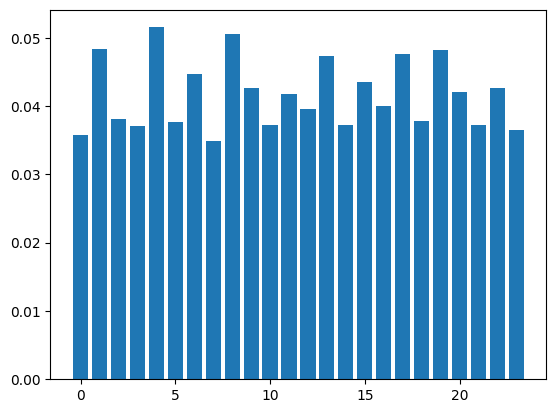

In [15]:
x = ft['train_data'][0] # uma unica amostra da serie, nao tem como fazer com todas
 

def get_op_from_ts(x, dx, dy=1, taux=10):
    
    """
    Applies the Bandt and Pompe symbolization approach to obtain 
    a probability distribution of ordinal patterns (permutations) from data, adapted from ordpy.
    
    Parameters
    ----------
    data : array 
           Array object in the shape (channels, len)
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).

    """

    symbols = ord.ordinal_sequence(x, dx=dx, dy= dy, taux=taux)

    if np.shape(symbols).__len__() == 3:
        symbols = symbols.reshape(-1, dx*dy) 
    else:
        pass
    
    all_symbols           = np.asarray(list(itertools.permutations(range(dx*dy))), dtype='int')
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)
    probabilities          = symbols_count/symbols_count.sum()

    all_symbols_str       = np.apply_along_axis(np.char.strip, 0, 
                                                np.apply_along_axis(np.array2string, 1, all_symbols, separator=''),
                                                chars="[]")

    if len(probabilities)==math.factorial(dx*dy):
        return dict(zip(all_symbols_str, probabilities))
    

    all_probs             = np.full(math.factorial(dx*dy), 0.)
    dict_probs = dict(zip(all_symbols_str, all_probs))

    for symbol, probability in zip(all_symbols_str, probabilities):
        dict_probs[symbol] = probability
    
    return dict_probs

dprob = get_op_from_ts(x, 4, 1)

plt.bar(range(len(dprob)), dprob.values())
